<a href="https://colab.research.google.com/github/hawkeyedatatsai/machine-learning-project-temp-/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

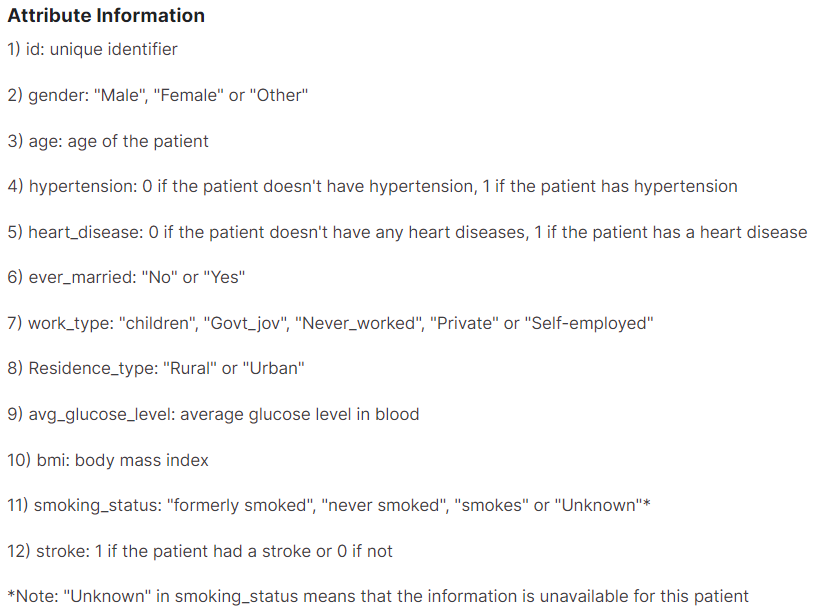

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
set_config(display='diagram')
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from google.colab import drive

#Stroke Prediction



##Introduction

###1. Source of data

Data set is from [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

###2. Brief description of data

According to the World Health Organization (WHO), stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.


###3. What is the target?



I intend to predict whether a patient is likely to get stroke, 1 for get stroke and 0 for not get stroke,based on the features like gender, age, various diseases, and smoking status. 

###4. What does one row represent? (A person?  A business?  An event? A product?)



Each row in the data provides relavant information about the patient.

###5. Is this a classification or regression problem?


It is going to be a classification problem since we are predicting with 1 and 0  whilst 1 means if the patient had a stroke and 0 means if not

###6. How many features does the data have?



In [ ]:
print(f' There are {df.shape[1]-1} featues in this data ')

NameError: ignored

###7. How many rows are in the dataset?


In [ ]:
print(f' There are {df.shape[0]} rows in this data ')

NameError: ignored

###8. What, if any, challenges do you foresee in cleaning, exploring, or modeling this dataset?



*   Cleaning: missing value

*   Exploring: finding out correlations between people with stroke AND their health ststus.

*   Modeling: will start with baseline, then add logreg, then end up with confusion matrix on oserving type 1 and type 2 errors.

#Data Cleaning
The following topics will be addressed
- Deleted unnecessary columns.
- Deleted duplicate rows.
- Identified and addressed missing values.
-Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats).
- Produced univariate visuals for the target and all features.
- Identified outliers.
- Clearly commented all of your cleaning steps and described any decisions you made.

In [ ]:
filename = "/content/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [ ]:
#decide to drop id since it doesnt help us make prediction
df = df.drop(["id"], axis=1)

In [ ]:
df.duplicated().sum()
#suggest no duplicate

0

In [ ]:
df.isna().sum()/len(df)*100
#slight missing values on BMI, can fill it back with simpleimputer later

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [ ]:
#check for inconsistent values in categorical columns
for col in list(df.select_dtypes(include='object')):
  print(col)
  print(df[col].value_counts())
  print()
#will drop "other" on gender since its very minor
#Plan to keep "Unknown" in smoking_status because its a huge portion of the col

gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



In [ ]:
df[df["gender"] == 'Other']
df.drop(df.loc[df["gender"] == 'Other'].index, inplace=True)
print(df.describe())
df.describe(include="object")

               age  hypertension  heart_disease  avg_glucose_level  \
count  5109.000000   5109.000000    5109.000000        5109.000000   
mean     43.229986      0.097475       0.054022         106.140399   
std      22.613575      0.296633       0.226084          45.285004   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.240000   
50%      45.000000      0.000000       0.000000          91.880000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

              bmi       stroke  
count  4908.00000  5109.000000  
mean     28.89456     0.048738  
std       7.85432     0.215340  
min      10.30000     0.000000  
25%      23.50000     0.000000  
50%      28.10000     0.000000  
75%      33.10000     0.000000  
max      97.60000     1.000000  


,gender,ever_married,work_type,Residence_type,smoking_status
count,5109,5109,5109,5109,5109
unique,2,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2924,2596,1892


- [From this link](https://my.clevelandclinic.org/health/diagnostics/12363-blood-glucose-test) , glucose level between 70-99 mg/dl is considered normal whilst 100-125 suggests prediabetes. If the blood glucose level is 126 mg/dl (7.0 mmol/L) or higher on more than one testing occasion, it usually means diabetes. Therefore, I do not plan to change anything on "avg_glucose_level".

- max bmi 97 is still in reasonable range when talking abt extreme obesity scenario.


#Exploratory Data

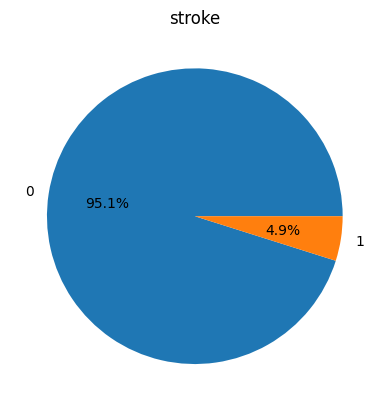

In [21]:
#TARGET!!
counts = df['stroke'].value_counts()
labels = counts.index.tolist()
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('stroke')
plt.show()

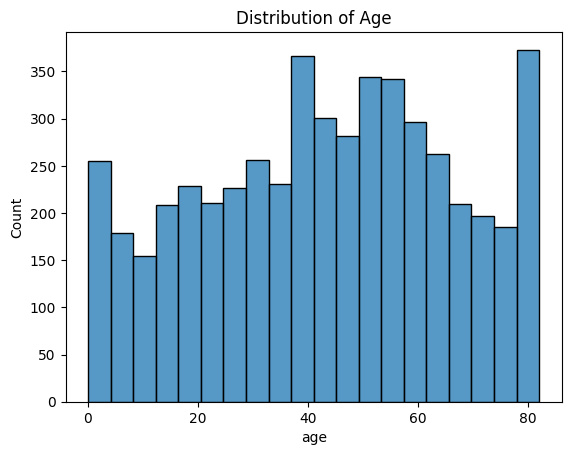

In [ ]:
ax = sns.histplot(data=df,
                  x='age',
                  bins="auto")

## Set the Title
ax.set_title('Distribution of Age');

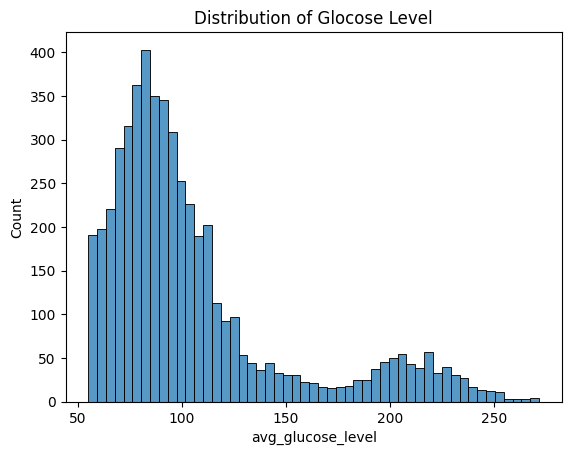

In [ ]:
ax = sns.histplot(data=df,
                  x='avg_glucose_level',
                  bins="auto")

## Set the Title
ax.set_title('Distribution of Glocose Level');

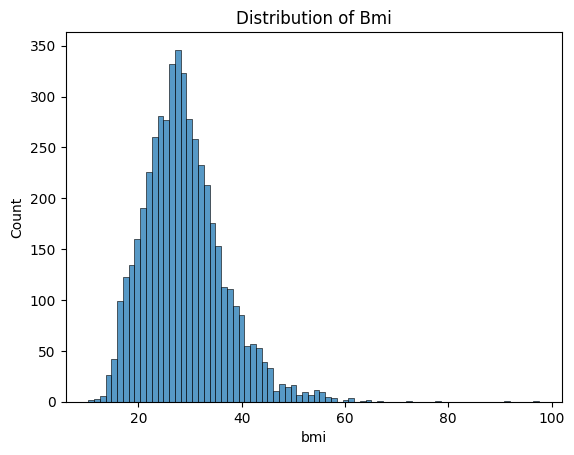

In [ ]:
ax = sns.histplot(data=df,
                  x='bmi',
                  bins="auto")

## Set the Title
ax.set_title('Distribution of Bmi');

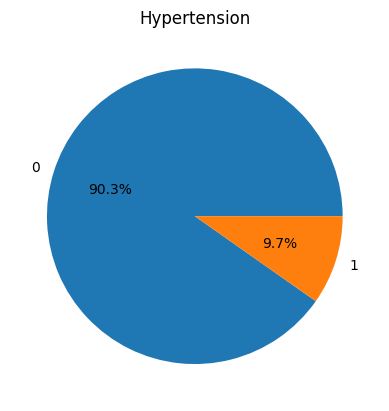

In [19]:
counts = df['hypertension'].value_counts()
labels = counts.index.tolist()
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('Hypertension')
plt.show()

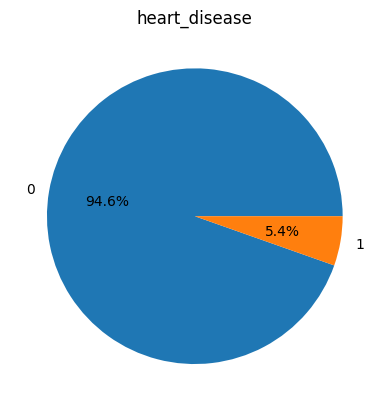

In [20]:
counts = df['heart_disease'].value_counts()
labels = counts.index.tolist()
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title('heart_disease')
plt.show()

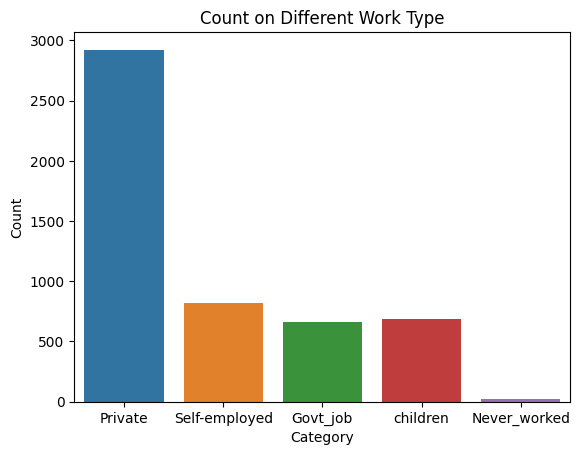

In [24]:
sns.countplot(x='work_type', data=df)
plt.title('Count on Different Work Type')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

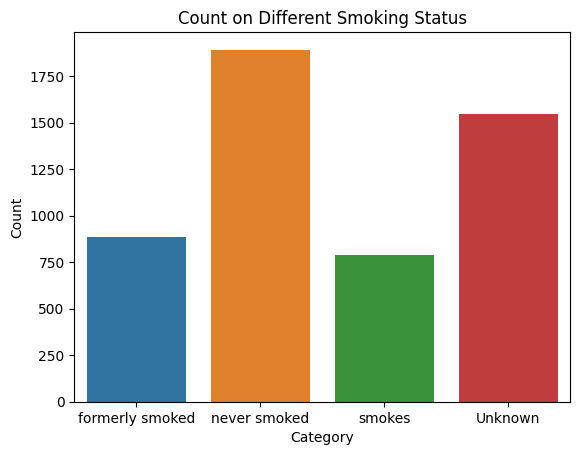

In [25]:
sns.countplot(x='smoking_status', data=df)
plt.title('Count on Different Smoking Status')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

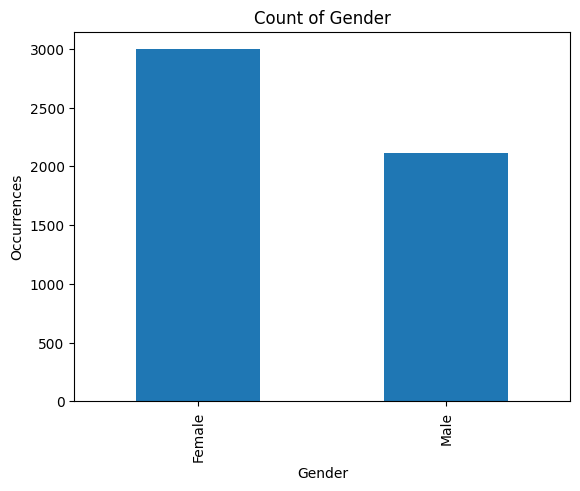

In [26]:
counts = df['gender'].value_counts()
counts.plot.bar()
plt.title('Count of Gender')
plt.xlabel('Gender')
plt.ylabel('Occurrences')
plt.show()

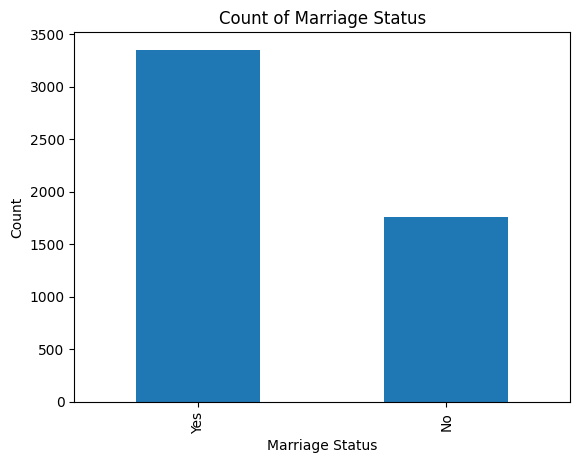

In [27]:
counts = df['ever_married'].value_counts()
counts.plot.bar()
plt.title('Count of Marriage Status')
plt.xlabel('Marriage Status')
plt.ylabel('Count')
plt.show()

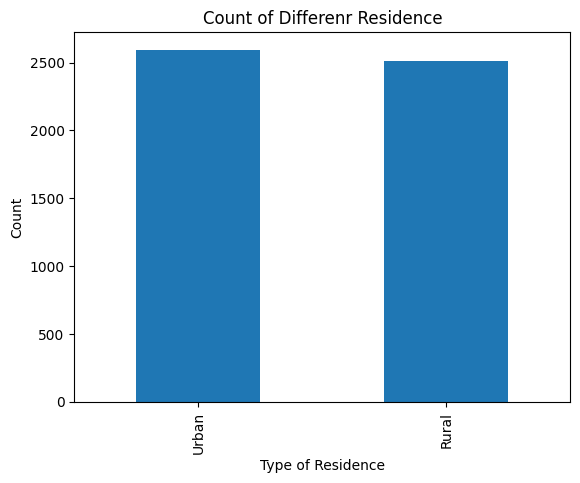

In [28]:
counts = df['Residence_type'].value_counts()
counts.plot.bar()
plt.title('Count of Differenr Residence')
plt.xlabel('Type of Residence')
plt.ylabel('Count')
plt.show()